In [1]:
import pickle
with open('ROMS_26yr_daydic.pkl', 'rb') as file:
    daydic = pickle.load(file)

with open('ROMS_26yr_eddies.pkl', 'rb') as file:
    eddies = pickle.load(file)

In [2]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho  = dataset.variables['lon_rho'][:]
lon_rho = np.transpose(lon_rho, axes=(1, 0))
lat_rho  = dataset.variables['lat_rho'][:]
lat_rho = np.transpose(lat_rho, axes=(1, 0))
z_r = np.load('/home/z5297792/UNSW-MRes/MRes/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))
previous_file_idx = -1
TOTAL_NUM_DAYS = len(daydic)

In [3]:
import re
def extract_number(s):
    match = re.search(r'\d+', s)
    return int(match.group()) if match else None

def grid_finder(i_search, j_search, SEARCH_WIDTH):
    fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
    dataset = nc.Dataset(fname)
    lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
    lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
    
    def within_search_width(i_offset, j_offset):
        return distance(lat_rho[i_search, j_search], lon_rho[i_search, j_search],
                        lat_rho[i_search + i_offset, j_search + j_offset], 
                        lon_rho[i_search + i_offset, j_search + j_offset]) < SEARCH_WIDTH / 2

    i_left, i_right = 0, 0
    j_down, j_up = 0, 0

    while i_search - i_left >= 0 and within_search_width(-i_left, 0):
        i_left += 1
    while i_search + i_right < lon_rho.shape[0] and within_search_width(i_right, 0):
        i_right += 1
    while j_search - j_down >= 0 and within_search_width(0, -j_down):
        j_down += 1
    while j_search + j_up < lon_rho.shape[1] and within_search_width(0, j_up):
        j_up += 1

    i_left = max(i_search - i_left + 1, 0)
    i_right = min(i_search + i_right, lon_rho.shape[0])
    j_down = max(j_search - j_down + 1, 0)
    j_up = min(j_search + j_up, lon_rho.shape[1])

    return i_left, i_right, j_down, j_up

def eddies_nearest_rho(elon, elat):
    dataset = nc.Dataset('/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc')
    lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
    lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
    R = np.sqrt((lon_rho - elon)**2 + (lat_rho - elat)**2)
    i_search, j_search = np.unravel_index(np.argmin(R), R.shape)
    return i_search, j_search

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357000
    lat1_rad, lon1_rad = np.radians(lat1), np.radians(lon1)
    lat2_rad, lon2_rad = np.radians(lat2), np.radians(lon2)
    dlat, dlon = lat2_rad - lat1_rad, lon2_rad - lon1_rad
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

def find_global_maxima(matrix):
    i_max, j_max = np.unravel_index(np.argmax(matrix, axis=None), matrix.shape)
    return i_max, j_max

def find_local_maxima(matrix):
    def is_local_maxima(matrix, i, j):
        rows, cols = matrix.shape
        value = matrix[i, j]
        if np.isnan(value):
            return False
        def is_valid_and_greater_than(value, neighbor):
            return not np.isnan(neighbor) and neighbor > value
        if i > 0 and is_valid_and_greater_than(value, matrix[i - 1, j]):
            return False
        if i < rows - 1 and is_valid_and_greater_than(value, matrix[i + 1, j]):
            return False
        if j > 0 and is_valid_and_greater_than(value, matrix[i, j - 1]):
            return False
        if j < cols - 1 and is_valid_and_greater_than(value, matrix[i, j + 1]):
            return False
        if i > 0 and j > 0 and is_valid_and_greater_than(value, matrix[i - 1, j - 1]):
            return False
        if i > 0 and j < cols - 1 and is_valid_and_greater_than(value, matrix[i - 1, j + 1]):
            return False
        if i < rows - 1 and j > 0 and is_valid_and_greater_than(value, matrix[i + 1, j - 1]):
            return False
        if i < rows - 1 and j < cols - 1 and is_valid_and_greater_than(value, matrix[i + 1, j + 1]):
            return False
        return True
    i_max, j_max, value_max = [], [], []
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            if is_local_maxima(matrix, i, j):
                i_max.append(i)
                j_max.append(j)
                value_max.append(matrix[i, j])
    return i_max, j_max, value_max

def eddies_nearest_rho(elon, elat):
    dataset = nc.Dataset('/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc')
    lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
    lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
    R = np.sqrt((lon_rho - elon)**2 + (lat_rho - elat)**2)
    i_search, j_search = np.unravel_index(np.argmin(R), R.shape)
    return i_search, j_search

def get_variable_name(var):
    for name, value in globals().items():
        if value is var:
            return name
    return None

def make_cartesian(lon, lat, theta0, phi0):
    lonr = np.deg2rad(lon)
    latr = np.deg2rad(lat)
    r_earth = 6371
    x = r_earth * np.cos(phi0) * (lonr - theta0)
    y = r_earth * (latr - phi0)
    return x, y

def eddy_centric_grid_distances(i_search, j_search, i_left, i_right, j_down, j_up):
    lonc = lon_rho[i_search, j_search]
    latc = lat_rho[i_search, j_search]
    def make_left_values_negative(arr):
        zero_index = np.where(arr == 0)[0]
        if zero_index.size == 0:
            return arr
        zero_index = zero_index[0]
        arr[:zero_index] = -np.abs(arr[:zero_index])
        return arr
    x = make_left_values_negative(distance(latc, lonc, lat_rho[i_left:i_right,j_search], lon_rho[i_left:i_right,j_search]))
    y = make_left_values_negative(distance(latc, lonc, lat_rho[i_search,j_down:j_up], lon_rho[i_search,j_down:j_up]))
    return x/1000, y/1000

def rotate_30_clockwise(x, y):
    theta = np.deg2rad(30)
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])
    points = np.vstack((x, y))
    rotated_points = rotation_matrix @ points
    x_rotated, y_rotated = rotated_points
    return x_rotated, y_rotated

def extract_contour(level_to_extract, plot):
    for level_paths in plot.allsegs:
        for path in level_paths:
            xt = path[:, 0]
            yt = path[:, 1]
            return xt, yt
    else:
        return [], []

def normalize_matrix(matrix):
    matrix = np.array(matrix)
    std_dev = np.nanstd(matrix)
    normalized_matrix = matrix / std_dev
    return normalized_matrix

previous_file_idx = -1

In [4]:
edata = eddies['Eddy17'].iloc[3] #E22T5
t = extract_number(edata.name)

mcolor = 'r' if edata.Vort > 0 else 'c'
colormap = 'Reds' if edata.Vort > 0 else 'Blues'

temp_ave = np.load('/srv/scratch/z5297792/Climatology/temp_ave.npy')
CurSpeed_ave = np.load('/srv/scratch/z5297792/Climatology/CurSpeed_ave.npy')

t_mod = t % 30
file_idx = np.floor(t/30)
if file_idx != previous_file_idx:
    
    fnumber = '0'+str(round(1461+ file_idx*30))
    fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_'+fnumber+'.nc'
    dataset = nc.Dataset(fname)
    
    U = np.load('/srv/scratch/z5297792/Climatology/u_v/u_'+fnumber+'.npy')
    V = np.load('/srv/scratch/z5297792/Climatology/u_v/v_'+fnumber+'.npy')
    Vorticity = np.load('/srv/scratch/z5297792/Climatology/vorts/vort_'+fnumber+'.npy')
    TemperatureAnomaly = np.load('/srv/scratch/z5297792/Climatology/temps/temp_'+fnumber+'.npy') - np.repeat(temp_ave[:, :, :, np.newaxis], 30, axis=3)
    CurSpeed = np.load('/srv/scratch/z5297792/Climatology/ow_and_cur_speeds/cur_speed_'+fnumber+'.npy')
    CurSpeedAnomaly = CurSpeed - np.repeat(CurSpeed_ave[:, :, :, np.newaxis], 30, axis=3)
    OW = np.load('/srv/scratch/z5297792/Climatology/ow_and_cur_speeds/ow_'+fnumber+'.npy')
    ocean_time = dataset.variables['ocean_time'][:]
    
    previous_file_idx = file_idx

/scratch/pbs.5728590.kman.restech.unsw.edu.au/ipykernel_1520118/2508845608.py:4: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


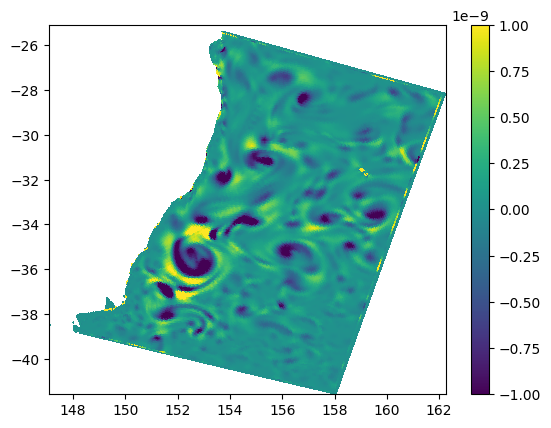

In [5]:
DEPTH_LVL = 8

plt.pcolor(lon_rho, lat_rho, OW[:,:,DEPTH_LVL,0],vmin=-1e-9,vmax=1e-9)
plt.colorbar()

/scratch/pbs.5728590.kman.restech.unsw.edu.au/ipykernel_1520118/2341974065.py:7: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


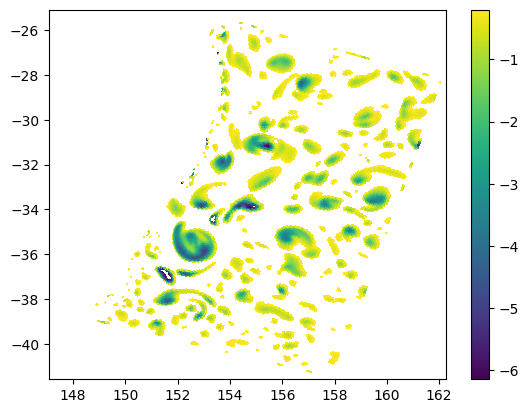

In [6]:
OW_lvl = OW[:,:,DEPTH_LVL,0]
OW_lvl[(OW_lvl>=.2e-8) | (OW_lvl<=-.2e-8) | (OW_lvl==0)] = np.nan
OW_norm = normalize_matrix(OW_lvl)
OW_norm[(OW_norm>-.2)] = np.nan

plt.pcolor(lon_rho, lat_rho, OW_norm)
plt.colorbar()

/scratch/pbs.5728590.kman.restech.unsw.edu.au/ipykernel_1520118/1621156663.py:14: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


(np.float64(151.2625964736248),
 np.float64(154.02920528861966),
 np.float64(-36.67130571780649),
 np.float64(-34.318987580631244))

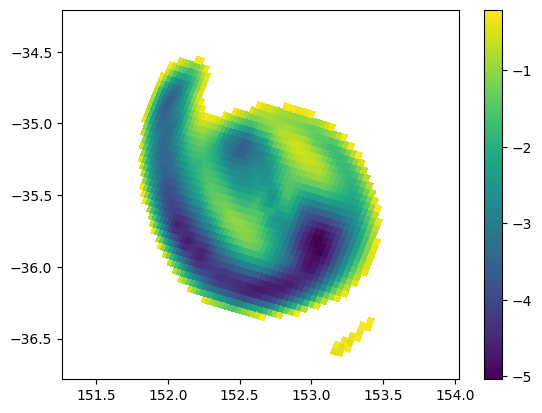

In [7]:
edata = daydic['Day1'].loc['Eddy22'] #E17. E4

SEARCH_WIDTH = 200000

i_search, j_search = eddies_nearest_rho(edata.Lon, edata.Lat)
i_left, i_right, j_down, j_up = grid_finder(i_search, j_search, SEARCH_WIDTH)

lon = lon_rho[i_left:i_right,j_down:j_up]
lat = lat_rho[i_left:i_right,j_down:j_up]

OW_norm_eddy = OW_norm[i_left:i_right,j_down:j_up]

plt.pcolor(lon, lat, OW_norm_eddy)
plt.colorbar()
plt.axis('equal')

In [8]:
import numpy as np
from scipy.ndimage import label

def group_connected_regions(matrix):
    binary_matrix = np.where(np.isnan(matrix), 0, 1)
    structure = np.ones((3, 3), dtype=int)
    labeled_matrix, _ = label(binary_matrix, structure=structure)
    result_matrix = np.full_like(matrix, np.nan)
    result_matrix[~np.isnan(matrix)] = labeled_matrix[~np.isnan(matrix)]
    return result_matrix

def compute_flow_directions(u, v):
    nan_mask = np.isnan(u) | np.isnan(v)
    direction_matrix = np.full(u.shape, np.nan)
    valid_mask = ~nan_mask
    u_valid, v_valid = u[valid_mask], v[valid_mask]
    
    if u_valid.size > 0:
        angles_degrees = np.degrees(np.arctan2(v_valid, u_valid)) % 360
        direction_matrix_valid = np.zeros(u_valid.shape, dtype=int)
        direction_matrix_valid[(angles_degrees >= 0) & (angles_degrees < 90)] = 1
        direction_matrix_valid[(angles_degrees >= 90) & (angles_degrees < 180)] = 2
        direction_matrix_valid[(angles_degrees >= 180) & (angles_degrees < 270)] = 3
        direction_matrix_valid[(angles_degrees >= 270) & (angles_degrees < 360)] = 4
        direction_matrix[valid_mask] = direction_matrix_valid
    
    return direction_matrix

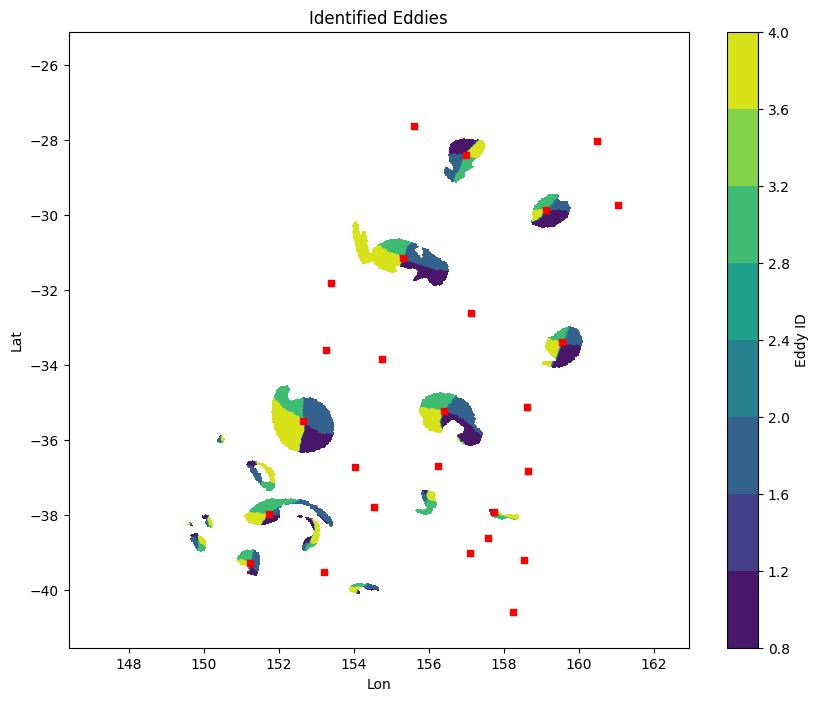

In [9]:
import numpy as np
import matplotlib.pyplot as plt

id_matrix = group_connected_regions(OW_norm)

# Mask u and v based on id_matrix
u_masked = np.where(np.isnan(id_matrix), np.nan, U[:, :, DEPTH_LVL, 0])
v_masked = np.where(np.isnan(id_matrix), np.nan, V[:, :, DEPTH_LVL, 0])

# Calculate the flow directions
direction_matrix = compute_flow_directions(u_masked, v_masked)

# Initialize the eddy mask with NaN values
eddy_masked = np.full(lon_rho.shape, np.nan)

i = 1  # Counter for identified eddies
for eid in range(1, int(np.nanmax(id_matrix)) + 1):  # Loop through eddy IDs
    # Mask for current eddy
    egroup = id_matrix != eid
    edirection = np.where(egroup, np.nan, direction_matrix)
    
    # Calculate the number of occurrences of each direction, ignoring NaNs
    dir1 = np.nansum(edirection == 1)
    dir2 = np.nansum(edirection == 2)
    dir3 = np.nansum(edirection == 3)
    dir4 = np.nansum(edirection == 4)
    
    total = dir1 + dir2 + dir3 + dir4
    
    # Check if all directions are represented above 8% threshold
    if total > 0:  # Avoid division by zero
        if (dir1 / total >= 0.08 and 
            dir2 / total >= 0.08 and 
            dir3 / total >= 0.08 and 
            dir4 / total >= 0.08):
            # Mark this eddy in the mask
            eddy_masked = np.where(egroup, eddy_masked, i)
            i += 1

# Plot the resulting eddy mask
plt.figure(figsize=(10, 8))
plt.contourf(lon_rho, lat_rho, np.where(np.isnan(eddy_masked), np.nan, direction_matrix))
plt.axis('equal')
plt.colorbar(label="Eddy ID")
plt.title("Identified Eddies")

ddata = daydic['Day1']
ddata.plot(kind='scatter', x='Lon', y='Lat', marker='s', ax=plt.gca(), color='r')

plt.show()


## 3D

In [10]:
import numpy as np
from scipy.ndimage import label, find_objects

def group_connected_regions_3d(matrix):
    binary_matrix = np.where(np.isnan(matrix), 0, 1)
    structure = np.ones((3, 3, 3), dtype=int)
    labeled_matrix, num_features = label(binary_matrix, structure=structure)
    slices = find_objects(labeled_matrix)
    result_matrix = np.full_like(matrix, np.nan)

    j = 0
    for i in range(1, num_features + 1):
        region_slice = slices[i - 1]
        if np.sum(labeled_matrix[region_slice] == i) >= 50:
            result_matrix[region_slice][labeled_matrix[region_slice] == i] = j
            j += 1
    
    return result_matrix



In [11]:
DEPTH_LVL_LIMIT = 15

OW_norm_3D = np.full(np.shape(OW[:,:,:DEPTH_LVL_LIMIT,0].squeeze()), np.nan)
for depth_lvl in range(DEPTH_LVL_LIMIT):
    OW_lvl = OW[:,:,depth_lvl,0]
    OW_lvl[(OW_lvl>=.2e-8) | (OW_lvl<=-.2e-8) | (OW_lvl==0)] = np.nan
    OW_norm = normalize_matrix(OW_lvl)
    OW_norm[(OW_norm>-.2)] = np.nan

    OW_norm_3D[:,:, depth_lvl] = OW_norm

id_matrix_3D = group_connected_regions_3d(OW_norm_3D)


In [12]:
m = 0
e = 0
for i in range(int(np.nanmax(id_matrix_3D))):
    d = np.nansum(id_matrix_3D==i)
    if d > m:
        m = d

        e = i



In [38]:
e

29

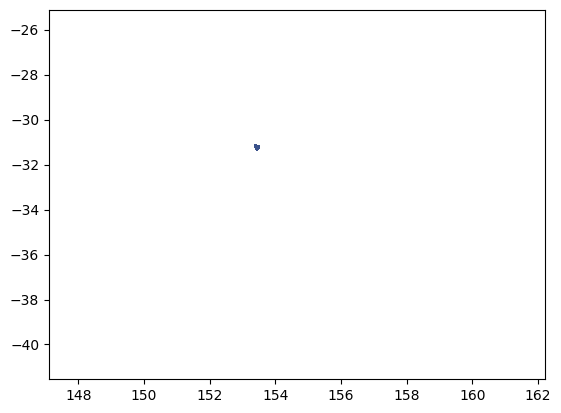

In [46]:
plt.contourf(lon_rho, lat_rho, np.where(id_matrix_3D[:,:,8]!=28, np.nan, id_matrix_3D[:,:,8]))

In [15]:

# Mask u and v based on id_matrix
u_masked_3D = np.where(np.isnan(id_matrix_3D), np.nan, U[:, :, :DEPTH_LVL_LIMIT, 0])
v_masked_3D = np.where(np.isnan(id_matrix_3D), np.nan, V[:, :, :DEPTH_LVL_LIMIT, 0])

# Calculate the flow directions
direction_matrix_3D = compute_flow_directions(u_masked_3D, v_masked_3D)

# Initialize the eddy mask with NaN values
eddy_masked_3D = np.full(u_masked_3D.shape, np.nan)

i = 1  # Counter for identified eddies
for eid in range(1, int(np.nanmax(id_matrix_3D)) + 1):  # Loop through eddy IDs
    # Mask for current eddy
    egroup = id_matrix_3D != eid
    edirection = np.where(egroup, np.nan, direction_matrix_3D)
    
    # Calculate the number of occurrences of each direction, ignoring NaNs
    dir1 = np.nansum(edirection == 1)
    dir2 = np.nansum(edirection == 2)
    dir3 = np.nansum(edirection == 3)
    dir4 = np.nansum(edirection == 4)
    
    total = dir1 + dir2 + dir3 + dir4
    
    # Check if all directions are represented above 8% threshold
    if total > 0:  # Avoid division by zero
        if (dir1 / total >= 0.08 and 
            dir2 / total >= 0.08 and 
            dir3 / total >= 0.08 and 
            dir4 / total >= 0.08):
            # Mark this eddy in the mask
            eddy_masked_3D = np.where(egroup, eddy_masked_3D, i)
            i += 1

direction_matrix_3D = np.where(np.isnan(eddy_masked_3D), np.nan, direction_matrix_3D)
            

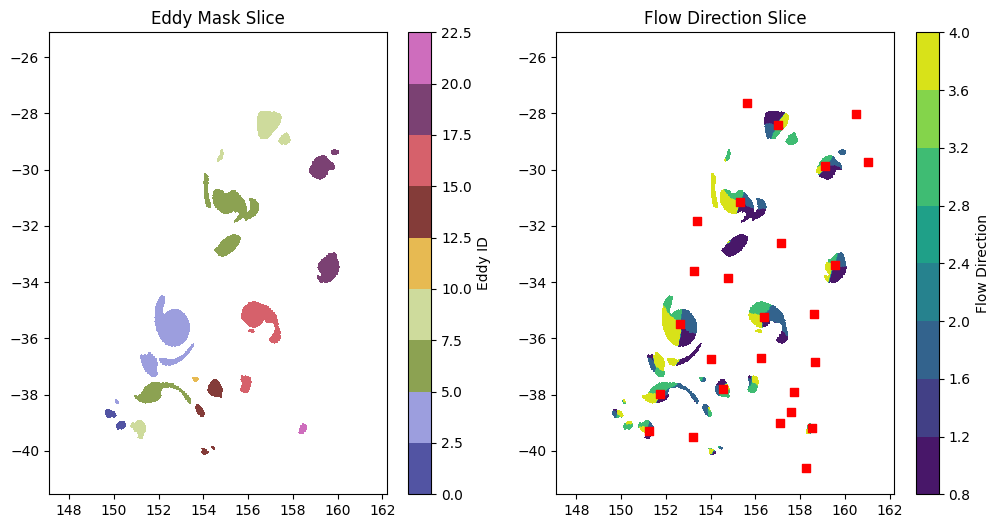

In [39]:
slice_index = 14

# Plot the slice of the resulting eddy mask and direction matrix
plt.figure(figsize=(12, 6))

# Plot eddy mask
plt.subplot(1, 2, 1)
plt.contourf(lon_rho, lat_rho, eddy_masked_3D[:, :, slice_index], cmap='tab20b')
plt.colorbar(label="Eddy ID")
plt.title("Eddy Mask Slice")

# Plot direction matrix
plt.subplot(1, 2, 2)
plt.contourf(lon_rho, lat_rho, direction_matrix_3D[:, :, slice_index], cmap='viridis')
plt.colorbar(label="Flow Direction")
plt.title("Flow Direction Slice")

# Scatter plot on the same axis
ddata = daydic['Day1']
plt.scatter(ddata['Lon'], ddata['Lat'], c='r', marker='s')

plt.show()

In [17]:
methods = ['Extrema Method', 'COW', 'MOCA', 'SSIM', 'CCC']
mcolors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:len(methods)]
df = pd.DataFrame({'Methods': methods, 'Color': mcolors})
df.index += 1
df

,Methods,Color
1,Extrema Method,#1f77b4
2,COW,#ff7f0e
3,MOCA,#2ca02c
4,SSIM,#d62728
5,CCC,#9467bd


In [55]:
x, y, z, c = [], [], [], []
for i in range(eddy_masked_3D.shape[0]):
    for j in range(eddy_masked_3D.shape[1]):
        for k in range(eddy_masked_3D.shape[2]):
            if ~np.isnan(eddy_masked_3D[i,j,k]):
                # if eddy_masked_3D[i,j,k] == 13:
        
                x.append(lon_rho[i, j])
                y.append(lat_rho[i, j])
                z.append(z_r[i, j, k])  # Adjust indexing based on your z_r array
                c.append(mcolors[int(direction_matrix_3D[i,j,k])])

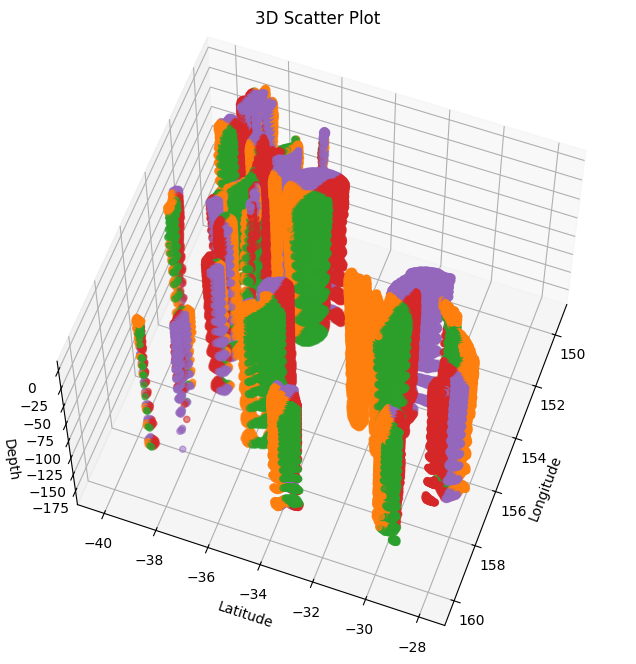

In [61]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Convert lists to numpy arrays for plotting
x = np.array(x)
y = np.array(y)
z = np.array(z)

# Plot scatter
ax.scatter(x, y, z, c=c)  # You can customize color and marker
ax.view_init(elev=60, azim=20)

# Label axes
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Depth')

plt.title('3D Scatter Plot')
plt.show()